In [538]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

In [539]:
pd.set_option('display.max_columns', None)

In [540]:
zri = pd.read_csv('df4.csv', index_col=0)
zri['MortDeliq30-89'] = zri['MortDeliq30-89'].fillna(zri['MortDeliq30-89'].mean())
zri['MortDeliq90'] = zri['MortDeliq90'].fillna(zri['MortDeliq90'].mean())
zri['education'] = zri['high_school_diploma'] + zri['associates_degree'] * 2 + zri['bachelors_degree'] * 3 +zri['masters_degree']* 4
zri['AGIncome'] = (zri['AGIncome']*1000)/zri['total_pop']
zri['TotIncome'] = (zri['TotIncome']*1000)/zri['total_pop']
zri['SalariesWages'] = (zri['SalariesWages']*1000)/zri['total_pop']
zri['NumUnemply'] =(zri['NumUnemply']*1000)/zri['total_pop']
zri['TotTaxes'] = (zri['TotTaxes']*1000)/zri['total_pop']



/home/jack/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6,7,8,9,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [541]:
dropped = [ 'City', 'State', 'Metro', 'CountyName', 'SizeRank',
       'Year-Month', 'value', 'Month', 'Year', 'year',  'geo_id', 'FIPSCode',
          'high_school_diploma', 'associates_degree', 'bachelors_degree',
       'masters_degree' , 'Employed', 'Unemployed', 'rental_units_supply',
          'AGIncome','TotIncome', 'SalariesWages', 'Labor\nForce', 'supply_change']

In [542]:
train = pd.merge(zri.loc[zri['Year']==2015].rename(columns = {'value' : 'value_prev'}),
                 zri.loc[zri['Year']==2018][['ZIPCODE', 'Month','value']],
                 how = 'left', on = ['ZIPCODE', 'Month'])
test = pd.merge(zri.loc[zri['Year']==2016].rename(columns = {'value' : 'value_prev'}),
                zri.loc[zri['Year']==2019][['ZIPCODE', 'Month','value']],
                how = 'left', on = ['ZIPCODE', 'Month'])
train = train.dropna()
test = test.dropna()
X_train = train.drop(columns = dropped)
X_test = test.drop(columns = dropped)
y_train = train['value']
y_test = test['value']

In [543]:
X_train.columns

Index(['value_prev'], dtype='object')

# XG Boost

In [534]:
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score

In [544]:
model1 = XGBRegressor(n_jobs = -1, max_depth = 3, n_estimators = 20)
model1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [545]:
print("The train set R^2 is %.3f" %(model1.score(X_train, y_train)))
print("The test set R^2 is %.3f" %(model1.score(X_test,y_test)))

The train set R^2 is 0.962
The test set R^2 is 0.949


In [548]:
from sklearn.metrics import mean_squared_error
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
print("R^2 Score:  %.2f" % (100*model1.score(X_train, y_train)))
print("Mean Error: $%.0f\n" % np.sqrt(mean_squared_error(y_test, y_pred)))

R^2 Score:  96.20
Mean Error: $134



In [403]:
model1.get_booster().get_score(importance_type="gain")

{'value_prev': 84288218.04051965,
 'ZIPCODE': 1276670.843499072,
 'natural_amenity_rank': 3694575.0480923075,
 'MortDeliq90': 855089.2211575002,
 'Unemploy-\\nment Rate\\n(%)': 456625.50813870976,
 'white_pop': 443677.35181818187,
 'NumUnemply': 480357.9601413793,
 'hispanic_pop': 433964.9609346153,
 'asian_pop': 466609.32649677416,
 'TotTaxes': 349729.080845,
 'MortDeliq30-89': 610056.5690022857,
 'income_per_capita': 264278.35098461533,
 'gini_index': 339617.87743000005,
 'black_pop': 255662.75171652174,
 'percent_income_spent_on_rent': 210585.8964083333,
 'housing_units_renter_occupied': 218564.014131579,
 'vacant_housing_units_for_rent': 205791.7499420833,
 'median_age': 210383.0879956522,
 'total_pop': 204140.97060400003,
 'income_change': 275791.04364999995,
 'Season': 119041.97424166666,
 'education': 242153.94184399996,
 'population_change': 212173.1959076923,
 'supply_change': 161018.6028473684}

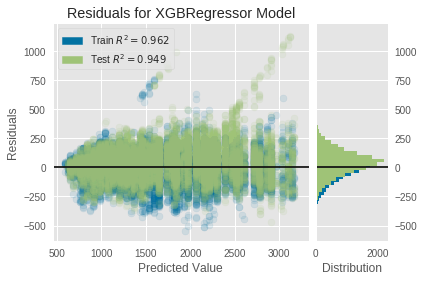

In [546]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot


# Instantiate the linear model and visualizer

visualizer = ResidualsPlot(model1, train_alpha = 0.1, test_alpha =0.1)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)# Evaluate ttrain_alpha = 0.1, test_alpha =0.01he model on the test data
#plt.ylim([-600, 600])
visualizer.show()                 # Finalize and render the figure

In [547]:
from sklearn.model_selection import cross_val_score

print(np.sqrt(-1* cross_val_score(model1, X_test, y_test, cv=5, scoring='neg_mean_squared_error', n_jobs =-1)))


[118.43730713 117.7884998  122.14727784 131.15141898 121.65117592]


In [203]:
predicted = pd.DataFrame(model1.predict(X_test))

In [190]:
X_test.iloc[13961]

ZIPCODE                          94610.000000
value_prev                        2556.000000
Season                               2.000000
NumUnemply                           5.134557
TotTaxes                          1000.000000
Unemploy-\nment Rate\n(%)            4.300000
MortDeliq30-89                       0.800000
MortDeliq90                          0.500000
total_pop                        31486.000000
median_age                          38.900000
white_pop                            0.525186
black_pop                            0.158832
asian_pop                            0.146732
hispanic_pop                         0.095471
gini_index                           0.465900
income_per_capita                58348.000000
vacant_housing_units_for_rent        0.015056
percent_income_spent_on_rent        24.900000
population_change                   -0.274315
income_change                        0.801531
natural_amenity_rank                 6.000000
education                         

In [183]:
pd.DataFrame(predicted['Predicted'], residuals['Residual Values'])

,Predicted
Residual Values,
-77.779053,NaN
-106.081177,NaN
-47.892334,NaN
-1.970093,NaN
-67.944153,NaN
...,...
14.760864,NaN
-86.389771,NaN
-127.913574,NaN


In [111]:
predicted = predicted.rename(columns={0: "Predicted"})

In [178]:
predicted

,Predicted
0,1800.779053
1,1361.081177
2,1919.892334
3,1327.970093
4,965.944153
...,...
15969,1887.239136
15970,1433.389771
15971,2327.913574
15972,1042.671387
